# TP Vocodeur de phase

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.fft import fft, ifft
import wave
from scipy.io.wavfile import write

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [4]:
from scipy.signal import stft, istft

## TFCT
### Généralités

In [5]:
Fe = 2000
t = np.arange(0, 1, 1/Fe)
x = np.sin(2*np.pi*100*t) + 2*np.sin(2*np.pi*200*t)
N = 2048
M = 256
R = 128
w = sig.hanning(M)

/var/folders/9l/gb5zsh4n7_5dc6vk35vdn5lw0000gn/T/ipykernel_1905/2739713345.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  w = sig.hanning(M)


In [6]:
def stft_custom(x, w, R, N, affichage = False):
    M = len(w)
    print(x.shape, M)
    
    x = np.concatenate((np.zeros(M), x, np.zeros(M))) # zero padding
    Nt = (len(x)-M)//R #+ 1 # nombre de trames
    print(f"{Nt=}", f"{len(x)=}", f"{(Nt-1)*R+M=}")
    Xtilde = np.zeros((Nt, N),dtype=complex)
    for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
        
        deb = u * R + 1 # début de trame
        fin = deb + M # fin de trame
        tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
        X = np.fft.fft(tx,N) # tfd à l'instant b
        Xtilde[u,:] = X
                
        f = np.arange(0,Fe,Fe/N)
        t = np.linspace(-M/Fe, (M+len(x))/Fe, Nt, endpoint=False)

    if affichage:
        print(f"{Xtilde.shape=}, {t.shape=}, {f.shape=}")
        plt.pcolormesh(t, f, 20*np.log10(np.abs(Xtilde.T)))
        plt.ylim(0, Fe/2)
        plt.show()
    return Xtilde

(2000,) 256
Nt=17 len(x)=2512 (Nt-1)*R+M=2304
Xtilde.shape=(17, 2048), t.shape=(17,), f.shape=(2048,)


/var/folders/9l/gb5zsh4n7_5dc6vk35vdn5lw0000gn/T/ipykernel_1905/3547295370.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 20*np.log10(np.abs(Xtilde.T)))


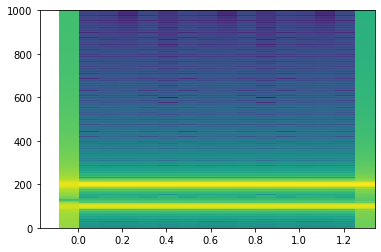

In [7]:
X_tilde = stft_custom(x, w, R, N, affichage = True)

((1025, 17), (17,), (1025,))

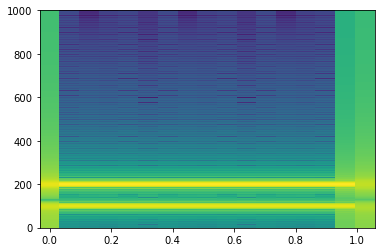

In [8]:
f, t, X = stft(x, Fe, nperseg=M, nfft=N, window=w, noverlap=M//2, padded=True)
plt.pcolormesh(t, f, 20*np.log10(np.abs(X)))
X.shape, t.shape, f.shape

#### a - Convention passe-bas

En convention passe-bas :
$$W_x(\lambda, b) = \sum_{n\in\mathbb{Z}} x(n) w(n-b)e^{-j2\pi\lambda n}$$
$$W_x(\lambda, b) = [x(n)e^{-j2\pi\lambda n} * w(-n)](b)$$

A $\lambda$ fixé, la définition "en convention passe-bas" de la TFCT correspond à une convolution de $x(n)e^{-j2\pi\lambda n}$ par le filtre $w(-n)$. 

Dans le domaine fréquentiel, on a multiplication $X(e^{j2\pi(\nu-\lambda)})$ : signal $x$ "démodulé" et $W(e^{j2\pi(-\nu)})$. C'est bien un filtrage passe-bas, afin de conserver les fréquences proches de $\lambda$ présentes dans $x$.

La fenêtre est toujours symétrique, on a donc un filtre de type I si elle est de longueur impaire, et de type II si elle est de longueur paire.

#### b - Convention passe-bande

En convention passe-bande :
$$\tilde{X}(\lambda, b) = \sum_{n\in\mathbb{Z}} x(n+b) w(n)e^{-j2\pi\lambda n}$$
$$\tilde{X}(\lambda, b) = \sum_{m\in\mathbb{Z}} x(m) w(m-b)e^{-j2\pi\lambda (m-b)}$$

On définit $h_\lambda (n)=e^{j2\pi\lambda n}w(-n)$ 

$$\tilde{X}(\lambda, b) = [x * h_\lambda](b)$$

A $\lambda$ fixé, la définition "en convention passe-bande" de la TFCT correspond à une convolution de $x(n)$ par le filtre $h_\lambda (n)$. 

$$\tilde{X}(\lambda, b) = \sum_{m\in\mathbb{Z}} x(m) w(m-b)e^{-j2\pi\lambda m} e^{j2\pi\lambda b}$$
$$\tilde{X}(\lambda, b) = e^{j2\pi\lambda b} W_x(\lambda, b) $$

La version implémentée ci-dessus est la TFCT "en convention passe-bande".

### c - Interprétation en terme de filtrage

In [9]:
import struct
wavefile = load_sound('song.wav')

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)[:5*Fs]

/var/folders/9l/gb5zsh4n7_5dc6vk35vdn5lw0000gn/T/ipykernel_1905/1266315604.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  w = sig.hanning(M)


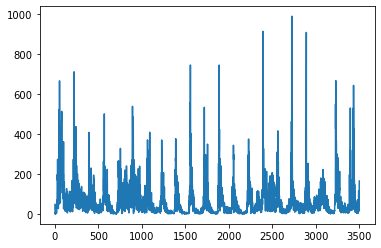

In [10]:
N = 64
M = 64
R = 1
w = sig.hanning(M)

# X_tilde = stft_custom(x, w, R, N, affichage = False) # Not used because it is too slow

_, _, X_tilde = stft(x, window=w, noverlap=R, nfft=N, padded=True, fs=Fs, nperseg=M)
X_tilde = X_tilde.T

k = 12
X_tilde[:, k]
plt.plot(np.abs(X_tilde[:, k]))

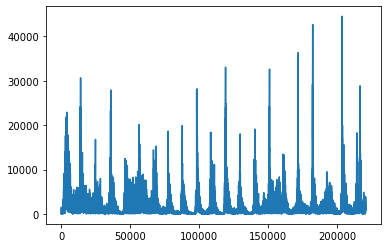

In [11]:
lambda_k = k/M
h_lambda = np.multiply(np.exp(2*1j*np.pi*lambda_k*np.arange(M)),w[::-1])
x_k = sig.lfilter(h_lambda, [1], x)
plt.plot(np.abs(x_k))

In [12]:
import pyaudio

write('filtered_song_k_12.wav', Fs, np.real(x_k)/np.max(np.real(x_k)))

In [13]:
k*Fs/N

8268.75

En écoutant le signal, on constate qu'il est filtré passe-haut, ce qui est logique puisqu'on se concentre sur le canal filtrant à $k F_s/N \simeq 8,3 kHz$.

On a bien le même résultat avec la méthode de filtrage et en prenant le $k^e$ canal de la STFT.

### Reconstruction

In [14]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

#### d - Condition de reconstruction parfaite

La reconstruction donne un signal $y(n)$:

$$y(n) = \sum_{u \in \mathbb{Z}} y_s (u, n-uR)$$

avec $y_s (u,n) = \frac{1}{M} \sum_{k=0}^{M-1}\tilde{X}(k,u) e^{2i\pi\frac{k}{M}n}w_s(n)$ où $\tilde{X}(k,u) = \sum_{n \in \mathbb{Z}} x(n+uR)w(n)e^{-2i\pi\frac{k}{M}n}$ 

En remplacant $y_s(n)$ et $\tilde{X}(k,u)$ on a:
$$y(n) = \sum_{u \in \mathbb{Z}} w_s (n-uR) \sum_{m=0}^{M} x(m+uR)w(m) \frac{1}{M} \sum_{k=0}^{M-1} e^{2i\pi \frac{k}{M} (n-m-uR)}$$
Or $\sum_{k=0}^{M-1} e^{2i\pi \frac{k}{M} (n-m-uR)} = \frac{1 - e^{2i\pi(n-m-uR)}}{1 - e^{2i\pi\frac{n-m-uR}{M}}} = \mathbb{I}_{n-m-uR \in M\mathbb{Z}}$

Etant donné que $m \in [0, R-1]$ et que $M\geq R$, cette indicatrice est non-nulle si et seulement si $m=n-uR$. On a donc
$$y(n) = \left[\sum_{u \in \mathbb{Z}}w_s(n - uR)w(n-uR)\right]x(n)$$
Une condition suffisante pour la reconstruction parfaite est donc:
$$\forall n \;\, f(n) = \sum_{u \in \mathbb{Z}}w_s(n - uR)w(n-uR) = 1$$

In [15]:
N = 1024
M = 256
R = M//4

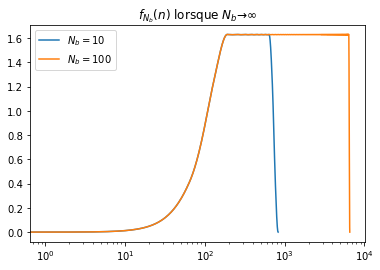

In [16]:
rec = 0.75
hop = int((1-rec)*M)
w = np.hanning(M)
Nb=10
f = ola(w**2, hop, Nb = Nb)
w_norm = np.sqrt(f[((Nb - 1) * hop + M)//2])
h = np.hanning(M)
h = h/w_norm

Nbs = [10, 100] #100, 1000, 10000
f_norm = [ola(h, hop, Nb = Nbs[i]) for i in range(len(Nbs))]
plt.figure()
plt.title(r'$f_{N_b}(n)$ lorsque $N_b \to \infty$')
for i in range(len(Nbs)):
    plt.plot(f_norm[i], label=r'$N_b = $' + str(Nbs[i]))
plt.legend()
#plt.hlines(1, xmin=0, xmax=len(f_norm[0]))
plt.xscale('log')

On voit bien que lorsque $N_b \to \infty$ on a la propriété qui tient pour tout $n$ (La causalité de l'algorithme ola fait que $f$ n'est pas une constante pour les basses valeurs de $n$)

In [20]:
w = np.hanning(M)/w_norm # définition de la fenetre d'analyse
ws = w.copy(); # définition de la fenêtre de synthèse
R = M//4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
hop = M-R
L = M/2+1
affich = 0 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((len(x) - M) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros(len(x)) # signal de synthèse

ola(ws*w, hop, Nb = Nt).shape


(660224, 1)

In [ ]:
w = np.hanning(M)/w_norm # définition de la fenetre d'analyse
ws = w.copy(); # définition de la fenêtre de synthèse
R = M//4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
hop = M-R
L = M/2+1
affich = 0 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((len(x) - M) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros(len(x)) # signal de synthèse
print(y.shape)


# We use the scipy function to compute the STFT, because it is faster
_, _, X_tilde = stft(x, window=w, noverlap=hop, nfft=N, padded=True, fs=Fs, nperseg=M)
X_tilde = X_tilde.T
print(X_tilde.shape, Nt)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + M # fin de trame
    y_s = ifft(X_tilde[u, :], M) # tfd inverse
    ty = np.multiply(np.real(y_s),ws)
    # ty = np.multiply(np.real(np.fft.ifft(Y, Nw)),ws)
    # overlap add

    y[int(deb):int(fin)] += ty
y = y/ola(ws*w, hop, Nb = Nt) # normalisation

plt.figure()
plt.plot(y)
plt.figure()
plt.plot(x)
    

(220500,)
(1724, 513) 1719


In [ ]:
import os
play = False
fn = f'overlap_add_song.wav'
write(fn, Fs, np.array(y, dtype=np.int16)) # to write a new wave file
data_path = os.getcwd()
sound = os.path.join(data_path, fn) 
if play :
    play_sound(sound) 

### Egaliseur Audio à TFCT

#### Q7 - Implémentation égaliseur et application passe-bas et passe-haut

In [ ]:
def egaliseur(x, weights, Nw = 512, rec=0.75, M=512, L=257):
    if len(weights) != M:
        raise Exception('Invalid size for weights. Must be equal to tfct order')
    w = np.hanning(Nw)/w_norm # définition de la fenetre d'analyse
    ws = w.copy(); # définition de la fenêtre de synthèse
    R = int((1-rec)*Nw) # incrément sur les temps d'analyse, appelé hop size, t_a=uR
    Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
    Nt = Nt.astype(int)
    y = np.zeros(N) # signal de synthèse
    for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
        deb = u * R + 1 # début de trame
        fin = deb + Nw # fin de trame
        tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
        X = np.fft.fft(tx,M) # tfd à l'instant b
        '''Y = X.copy()
        for k in range(M):
            Y[k] *= weights[k]'''
        Y = np.multiply(X,weights)
        ty = np.multiply(np.real(np.fft.ifft(Y, Nw)),ws)
        y[int(deb):int(fin)] += ty
    return y

#### Passe-bas

In [ ]:
Nw = 512
weights = np.zeros(Nw)
k_cutoff = 6
weights[:k_cutoff] = np.ones(k_cutoff)
weights[Nw-k_cutoff:] = np.ones(k_cutoff)
y = egaliseur(x, weights)
fn = f'new_caravan_equalizer_passe_bas_{int(k_cutoff/Nw * Fs)}Hz.wav'
write(fn, Fs, np.array(y, dtype=np.int16)) # to write a new wave file

#### Passe-haut

In [ ]:
Nw = 512
weights = np.ones(Nw)
k_cutoff = 10
weights[:k_cutoff] = np.zeros(k_cutoff)
weights[Nw-k_cutoff:] = np.zeros(k_cutoff)
y = egaliseur(x, weights)
fn = f'new_caravan_equalizer_passe_haut_{int(k_cutoff/Nw * Fs)}Hz.wav'
write(fn, Fs, np.array(y, dtype=np.int16)) # to write a new wave file